# Lab 11: A/B Testing and Causality

## 1. Ramen Ratings
Ramen is delicious, it's a well known fact, and different countries around the world make theirs in unique ways. But is there one country that makes better ramen than another? In this assignment, we will take utilize A/B testing to answer this question

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 

If we take a look at our data, we see that we have different columns regarding brand, variety, the style of noodle, etc. But for this lab, we'll be focusing on the country and stars. Namely, we'll be only focusing two ramen countries, Malaysia and Taiwan

In [3]:
ramen_df = pd.read_csv('ramen-ratings.csv')
ramen_df


,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN
...,...,...,...,...,...,...,...
2575,5,Vifon,"Hu Tiu Nam Vang [""Phnom Penh"" style] Asian Sty...",Bowl,Vietnam,3.5,NaN
2576,4,Wai Wai,Oriental Style Instant Noodles,Pack,Thailand,1,NaN
2577,3,Wai Wai,Tom Yum Shrimp,Pack,Thailand,2,NaN
2578,2,Wai Wai,Tom Yum Chili Flavor,Pack,Thailand,2,NaN


**Question 1**: Create a new data frame called `taiwan_and_malaysia` that only consists of data for countries Malaysia and Taiwan, and check the data type of the Stars column

In [28]:
taiwan_and_malaysia = ramen_df[(ramen_df.Country == 'Taiwan') | (ramen_df.Country == 'Malaysia')]


# cust_sell = mainDf[mainDf.Type == 'S']
# alldata[(alldata[IBRD] !=0) | (alldata[IMF] !=0)]v

print(taiwan_and_malaysia['Stars'].dtypes)

object


**Question 2:** We see here that the data type of the Stars column is a little unexpected, so we should do three things:



1.   Sort the column to find any values that we may not want
2.   Remove those values if there are any
3.   Update the Sort column to contain float values using **astype()**





In [29]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
taiwan_and_malaysia = taiwan_and_malaysia.replace('Unrated',0)

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html
taiwan_and_malaysia['Stars'].astype(float)

1       1.00
3       2.75
28      5.00
40      3.25
65      5.00
        ... 
2500    3.50
2512    4.00
2522    3.00
2537    0.00
2572    3.00
Name: Stars, Length: 380, dtype: float64

Now that we've cleaned up our data set, we can know visualize the distribution of ramen ratings for Taiwan and Malaysia. The code below creates an overlapped histogram of our data, and we can see that the distrubution of data in Taiwan is slightly left than that of Malaysia. This can suggest that ramen and Taiwan is rated lower than ramen in Malaysia.

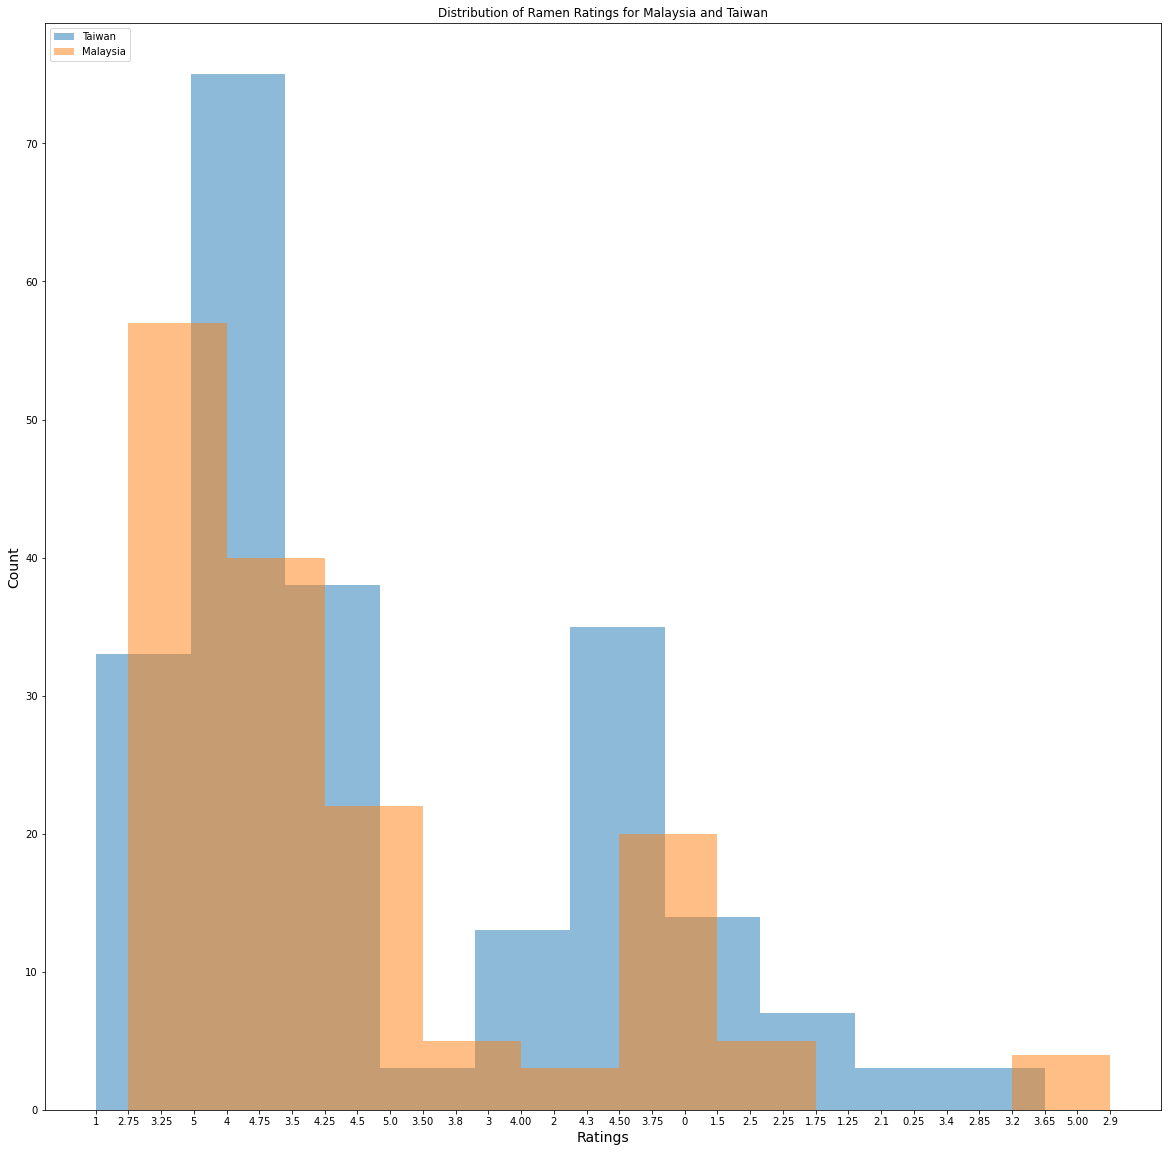

In [30]:
taiwan = []
malaysia = []
for index , row in taiwan_and_malaysia.iterrows():
    if row["Country"] == "Taiwan":
        taiwan.append(row["Stars"])
    else:
        malaysia.append(row["Stars"])

taiwan = np.array(taiwan)
malaysia = np.array(malaysia)

plt.figure(figsize=(20,20))
plt.hist(taiwan,bins=10,alpha=0.5,label="Taiwan")
plt.hist(malaysia,bins=10,alpha=0.5,label="Malaysia")
plt.xlabel("Ratings",size="14")
plt.ylabel("Count",size="14")
plt.title("Distribution of Ramen Ratings for Malaysia and Taiwan")
plt.legend(loc="upper left")

In order to do our A/B testing, we'll need to create our null and alternative and hypothesis. For all we know, the results shown in our histogram was simply chance, and does not reflect the population of Taiwanese and Malaysian ramen as whole:

**Null Hypothesis:** The distribution of ramen ratings is the same for both Taiwan and Malaysia. The difference in the data given to us is simply chance

**Alternative Hypothesis:** In population, ramen in Malaysia is rated higher than ramen Taiwan

Now, we can start our testing by only using the Country and Stars column, since that's all we'll be working with

**Question 3:** Create a new dataframe that consists of only the Country and Stars column

In [35]:
country_and_stars = taiwan_and_malaysia.drop(['Review #', 'Brand', 'Variety', 'Style','Top Ten'], axis=1)
country_and_stars

,Country,Stars
1,Taiwan,1
3,Taiwan,2.75
28,Malaysia,5
40,Taiwan,3.25
65,Taiwan,5
...,...,...
2500,Taiwan,3.5
2512,Taiwan,4
2522,Taiwan,3
2537,Taiwan,0


**Question 4:** Complete the function difference_of_rating_average which takes in a dataframe and an optional column name and returns the difference in stars average for Malaysia and Taiwan. Get the difference in average for the dataframe you made in question 3

**Note:** the parameter, `column_name="Country"` means that if no column name gets passed in when the function is called, it'll use the Country column by default

In [46]:
def difference_of_rating_average(dataframe, column_name="Country"):
    taiwan = []
    malaysia = []
    for index , row in dataframe.iterrows():
        if row[column_name] == "Taiwan":
            taiwan.append(row["Stars"])
        elif row[column_name] == "Malaysia":
            malaysia.append(row["Stars"])
    taiwan = np.array(taiwan).astype(float)
    malaysia = np.array(malaysia).astype(float)
    avgtaiwan = sum(taiwan)/len(taiwan)
    avgmalaysia = sum(malaysia)/len(malaysia)
    diff = avgtaiwan - avgmalaysia
    return diff

The function written in Question 4 will help us in creating our simulation. The code below creates one simulation by taking in the entire dataframe of taiwan and malaysia made in Question 1, and making a new data frame from just the Country and Stars columns. From there, it creates a copy of that modified dataframe and adds anouther column, Shuffle which consists of the Country column being put in a random order, and calls `difference_of_rating_average` with the column name being the Shuffle column. 

**You can call the function using the dataframe you made in Question 1**

In [47]:
def one_simulated_difference(table):
    table1 = pd.concat([table["Country"],table["Stars"]],axis=1,keys=['Country','Stars'])
    shuffled_labels = table1["Country"].sample(frac=1).values

    shuffled_table = table1
    shuffled_table["Shuffle"] = shuffled_labels
    return difference_of_rating_average(table1,"Shuffle")

**Question 5**: Simulate running our single simulation function 100 times, store the results in an array, and plot the results using a histogram

(array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
        0., 1., 0., 1., 0., 0., 2., 1., 1., 1., 0., 1., 0., 0., 1., 2., 0.,
        3., 2., 0., 2., 0., 0., 2., 1., 1., 1., 1., 5., 0., 0., 2., 2., 1.,
        6., 0., 1., 1., 3., 3., 3., 4., 1., 1., 3., 2., 2., 1., 0., 2., 0.,
        0., 2., 2., 1., 3., 1., 1., 2., 2., 1., 3., 2., 0., 0., 2., 2., 1.,
        0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-2.95238095e-01, -2.89452839e-01, -2.83667582e-01, -2.77882326e-01,
        -2.72097070e-01, -2.66311813e-01, -2.60526557e-01, -2.54741300e-01,
        -2.48956044e-01, -2.43170788e-01, -2.37385531e-01, -2.31600275e-01,
        -2.25815018e-01, -2.20029762e-01, -2.14244505e-01, -2.08459249e-01,
        -2.02673993e-01, -1.96888736e-01, -1.91103480e-01, -1.85318223e-01,
        -1.79532967e-01, -1.73747711e-01, -1.67962454e-01, -1.62177198e-01,
        -1.56391941e-01, -1.50606685e-01, -1.44821429e-01, -1.39036172e-01,
        -1.3325091

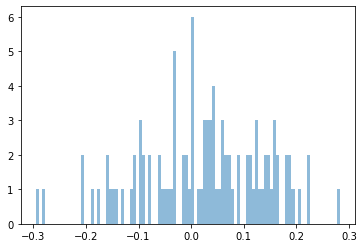

In [48]:
simm_arr = []
for i in range(100):
    simm_arr.append(one_simulated_difference(country_and_stars))

plt.hist(simm_arr,bins=len(simm_arr),alpha=0.5)


**Question 6**: Based on the the histogram you made, which hypothesis does the data favor.

It would seem like the null hypothesis is favored as 0.0 is the most common and each side(pos and neg) seems relatively balanced in frequency.

## 2. Pokemon Strength

Pokemon has been one of the most popular trading card games since it's release in the 1990s. For this section, we'll take a look at pokemon data to see if having a secondary type causes Pokemon to have higher total stats


In [118]:
pokemon_df = pd.read_csv('Pokemon.csv')
pokemon_df

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


**Question 1:** Create a new dataframe called `secondary_types` which consists of the the Type 2 and Total columns in pokemon_df, and update the Type 2 column such that rows with NaN will be set to 0 and rows without NaN will be set to 1. This will help us be able to see which pokemon have secondary types or not

In [121]:
secondary_types = pokemon_df.drop(['#', 'Name', 'Type 1', 'HP', 'Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation','Legendary'], axis=1)
# df.loc[index,'Name']=='Mr. Elon R. Musk'
for index in secondary_types.index:
    if (pd.isnull(row['Type 2'])):
        secondary_types.loc[index,'Type 2'] = 0
    elif (secondary_types.loc[index,'Type 2'] == "Poison") | (secondary_types.loc[index,'Type 2'] == "Bug") | (secondary_types.loc[index,'Type 2'] == "Dark") | (secondary_types.loc[index,'Type 2'] == "Dragon") | (secondary_types.loc[index,'Type 2'] == "Electric") | (secondary_types.loc[index,'Type 2'] == "Fairy") | (secondary_types.loc[index,'Type 2'] == "Fighting") | (secondary_types.loc[index,'Type 2'] == "Fire") | (secondary_types.loc[index,'Type 2'] == "Flying") | (secondary_types.loc[index,'Type 2'] == "Ghost") | (secondary_types.loc[index,'Type 2'] == "Grass") | (secondary_types.loc[index,'Type 2'] == "Ground") | (secondary_types.loc[index,'Type 2'] == "Ice") | (secondary_types.loc[index,'Type 2'] == "Normal") | (secondary_types.loc[index,'Type 2'] == "Psychic") | (secondary_types.loc[index,'Type 2'] == "Rock") | (secondary_types.loc[index,'Type 2'] == "Steel") | (secondary_types.loc[index,'Type 2'] == "Water"):
        secondary_types.loc[index,'Type 2'] = 1
    else:
        secondary_types.loc[index,'Type 2'] = 0

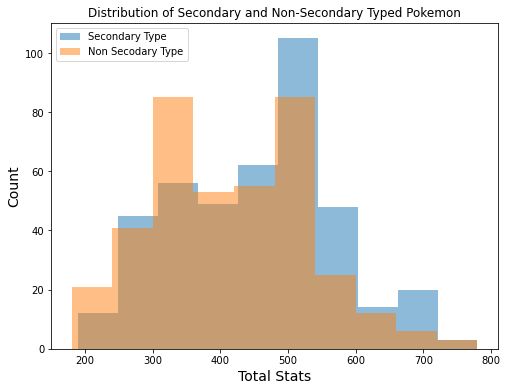

In [120]:
has_secondary = []
non_secondary = []

for index , row in secondary_types.iterrows():
    if row["Type 2"] == 0:
      non_secondary.append(row["Total"])
    else:
      has_secondary.append(row["Total"])

has_secondary = np.array(has_secondary)
non_secondary = np.array(non_secondary)

plt.figure(figsize=(8,6))
plt.hist(has_secondary,bins=10,alpha=0.5,label="Secondary Type")
plt.hist(non_secondary,bins=10,alpha=0.5,label="Non Secodary Type")
plt.xlabel("Total Stats",size="14")
plt.ylabel("Count",size="14")
plt.title("Distribution of Secondary and Non-Secondary Typed Pokemon")
plt.legend(loc="upper left")

We can see from this data that the non-secondary types are slightly left, which can indicate that not having a secondary type makes pokemon have less stats. But we can't jump to this conclusion without forming our hypotheses and creating a simulation

**Question:** What are our null and alternative hypotheses?

**Null Hypothesis:** The distribution of ratings is the same for both pokemon with and without secondary types. The difference in the data given to us is simply chance.

**Alternative Hypothesis:** In pokemon, pokemon with secondary types have higher stats than those without.

**Question 2:** Use the `secondary_types` dataframe you made to get the difference in mean total stats for Pokemon with and without a secondary type

In [122]:
secondary_types.groupby("Type 2").mean()

,Total
Type 2,
0,412.015544
1,456.628019


**Question 3:** Complete the function `simulated_difference_poke` which takes in no parameters. It should:


1.   Create a copy of table1 with an extra column that holds the values in Type 2 shuffled in random order
2.   returns the difference in mean total stats for pokemon with an without a secondary type



In [140]:
def simulated_difference_poke():
    table1 = pd.concat([pokemon_df["Type 2"],pokemon_df['Total']], axis = 1, keys = ["Type 2","Total"])
    table1["Type 2"] = (table1['Type 2'].notnull()).astype('int')

    shuffled_labels = table1["Type 2"].sample(frac=1).values
    diff = secondary_types.groupby("Type 2").mean()
    return diff['Total'][1]-diff['Total'][0]

In [141]:
simulated_difference_poke()

44.612475282220714

**Question 4:** Run your `simulated_difference_poke` code 1000 times and display the results using a histogram. If your code times out with 1000, feel free to use a smaller number like 500. You'll get a similar result either way.

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([44.11247528, 44.21247528, 44.31247528, 44.41247528, 44.51247528,
        44.61247528, 44.71247528, 44.81247528, 44.91247528, 45.01247528,
        45.11247528]),
 <BarContainer object of 10 artists>)

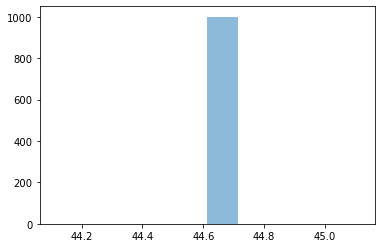

In [145]:
arr = []
for i in range(1000):
    arr.append(simulated_difference_poke())
plt.hist(arr,bins=10,alpha=0.5)

**Question 5:** What can you conclude about this data? Is it safe to say that having a secondary type causes pokemon to have higher total stats? Why or why not? If we calculate our P value, what does the result say about our data?

To be honest, running a this simulation didn't make much sense to me as the results show. What was the point of the random shuffle array with 1's and 0's? there's not much you can do with that and regardless the mean of both with stay the same.